In [1]:
cd /data/wlsgur4011/part_assembly/src/pointnext

/data/wlsgur4011/part_assembly/src/pointnext


In [2]:
import sys
sys.path.append("/data/wlsgur4011/part_assembly/src/pointnext/examples/segmentation/")
import sys
sys.argv = ["examples/segmentation/main.py", "--cfg", "cfgs/part_assembly/pointnext-l.yaml", "--debug"]

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [7]:
"""
(Distributed) training script for scene segmentation
This file currently supports training and testing on S3DIS
If more than 1 GPU is provided, will launch multi processing distributed training by default
if you only wana use 1 GPU, set `CUDA_VISIBLE_DEVICES` accordingly
"""
# import __init__
import argparse
import yaml
import os
import logging
import numpy as np
import csv
import wandb
import glob
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import distributed as dist, multiprocessing as mp
from torch.utils.tensorboard import SummaryWriter
from torch_scatter import scatter
from openpoints.utils import set_random_seed, save_checkpoint, load_checkpoint, resume_checkpoint, setup_logger_dist, \
    cal_model_parm_nums, Wandb, generate_exp_directory, resume_exp_directory, EasyConfig, dist_utils, find_free_port
from openpoints.utils import AverageMeter, ConfusionMatrix, get_mious
from openpoints.dataset import build_dataloader_from_cfg, get_features_by_keys, get_class_weights
from openpoints.dataset.data_util import voxelize
from openpoints.dataset.semantic_kitti.semantickitti import load_label_kitti, load_pc_kitti, remap_lut_read, remap_lut_write, get_semantickitti_file_list
from openpoints.transforms import build_transforms_from_cfg
from openpoints.optim import build_optimizer_from_cfg
from openpoints.scheduler import build_scheduler_from_cfg
from openpoints.loss import build_criterion_from_cfg
from openpoints.models import build_model_from_cfg
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


def write_to_csv(oa, macc, miou, ious, best_epoch, cfg, write_header=True, area=5):
    ious_table = [f'{item:.2f}' for item in ious]
    header = ['method', 'Area', 'OA', 'mACC', 'mIoU'] + cfg.classes + ['best_epoch', 'log_path', 'wandb link']
    data = [cfg.cfg_basename, str(area), f'{oa:.2f}', f'{macc:.2f}',
            f'{miou:.2f}'] + ious_table + [str(best_epoch), cfg.run_dir,
                                           wandb.run.get_url() if cfg.wandb.use_wandb else '-']
    with open(cfg.csv_path, 'a', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        if write_header:
            writer.writerow(header)
        writer.writerow(data)
        f.close()


def generate_data_list(cfg):
    if 's3dis' in cfg.dataset.common.NAME.lower():
        raw_root = os.path.join(cfg.dataset.common.data_root, 'raw')
        data_list = sorted(os.listdir(raw_root))
        data_list = [os.path.join(raw_root, item) for item in data_list if
                     'Area_{}'.format(cfg.dataset.common.test_area) in item]
    elif 'scannet' in cfg.dataset.common.NAME.lower():
        data_list = glob.glob(os.path.join(cfg.dataset.common.data_root, cfg.dataset.test.split, "*.pth"))
    elif 'semantickitti' in cfg.dataset.common.NAME.lower():
        if cfg.dataset.test.split == 'val':
            split_no = 1
        else:
            split_no = 2
        data_list = get_semantickitti_file_list(os.path.join(cfg.dataset.common.data_root, 'sequences'),
                                                str(cfg.dataset.test.test_id + 11))[split_no]
    else:
        raise Exception('{} dataset not supported yet'.format(args.data_name))
    return data_list


def load_data(data_path, cfg):
    label, feat = None, None
    if 's3dis' in cfg.dataset.common.NAME.lower():
        data = np.load(data_path)  # xyzrgbl, N*7
        coord, feat, label = data[:, :3], data[:, 3:6], data[:, 6]
        feat = np.clip(feat / 255., 0, 1).astype(np.float32)
    elif 'scannet' in cfg.dataset.common.NAME.lower():
        data = torch.load(data_path)  # xyzrgbl, N*7
        coord, feat = data[0], data[1]
        if cfg.dataset.test.split != 'test':
            label = data[2]
        else:
            label = None
        feat = np.clip((feat + 1) / 2., 0, 1).astype(np.float32)
    elif 'semantickitti' in cfg.dataset.common.NAME.lower():
        coord = load_pc_kitti(data_path[0])
        if cfg.dataset.test.split != 'test':
            label = load_label_kitti(data_path[1], remap_lut_read)
    coord -= coord.min(0)

    idx_points = []
    voxel_idx, reverse_idx_part, reverse_idx_sort = None, None, None
    voxel_size = cfg.dataset.common.get('voxel_size', None)

    if voxel_size is not None:
        # idx_sort: original point indicies sorted by voxel NO.
        # voxel_idx: Voxel NO. for the sorted points
        idx_sort, voxel_idx, count = voxelize(coord, voxel_size, mode=1)
        if cfg.get('test_mode', 'multi_voxel') == 'nearest_neighbor':
            idx_select = np.cumsum(np.insert(count, 0, 0)[0:-1]) + np.random.randint(0, count.max(), count.size) % count
            idx_part = idx_sort[idx_select]
            npoints_subcloud = voxel_idx.max() + 1
            idx_shuffle = np.random.permutation(npoints_subcloud)
            idx_part = idx_part[idx_shuffle]  # idx_part: randomly sampled points of a voxel
            reverse_idx_part = np.argsort(idx_shuffle, axis=0)  # revevers idx_part to sorted
            idx_points.append(idx_part)
            reverse_idx_sort = np.argsort(idx_sort, axis=0)
        else:
            for i in range(count.max()):
                idx_select = np.cumsum(np.insert(count, 0, 0)[0:-1]) + i % count
                idx_part = idx_sort[idx_select]
                np.random.shuffle(idx_part)
                idx_points.append(idx_part)
    else:
        idx_points.append(np.arange(label.shape[0]))
    return coord, feat, label, idx_points, voxel_idx, reverse_idx_part, reverse_idx_sort


def main(gpu, cfg):
    if cfg.distributed:
        if cfg.mp:
            cfg.rank = gpu
        dist.init_process_group(backend=cfg.dist_backend,
                                init_method=cfg.dist_url,
                                world_size=cfg.world_size,
                                rank=cfg.rank)
        dist.barrier()

    # logger
    setup_logger_dist(cfg.log_path, cfg.rank, name=cfg.dataset.common.NAME)
    if cfg.rank == 0:
        Wandb.launch(cfg, cfg.wandb.use_wandb)
        writer = SummaryWriter(log_dir=cfg.run_dir) if cfg.is_training else None
    else:
        writer = None
    set_random_seed(cfg.seed + cfg.rank, deterministic=cfg.deterministic)
    torch.backends.cudnn.enabled = True
    logging.info(cfg)

    if cfg.model.get('in_channels', None) is None:
        cfg.model.in_channels = cfg.model.encoder_args.in_channels
    model = build_model_from_cfg(cfg.model).to(cfg.rank)
    model_size = cal_model_parm_nums(model)
    logging.info(model)
    logging.info('Number of params: %.4f M' % (model_size / 1e6))
    
    model 
    exit()

    if cfg.sync_bn:
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
        logging.info('Using Synchronized BatchNorm ...')
    if cfg.distributed:
        torch.cuda.set_device(gpu)
        model = nn.parallel.DistributedDataParallel(model.cuda(), device_ids=[cfg.rank], output_device=cfg.rank)
        logging.info('Using Distributed Data parallel ...')

    # optimizer & scheduler
    optimizer = build_optimizer_from_cfg(model, lr=cfg.lr, **cfg.optimizer)
    scheduler = build_scheduler_from_cfg(cfg, optimizer)

    # build dataset
    val_loader = build_dataloader_from_cfg(cfg.get('val_batch_size', cfg.batch_size),
                                           cfg.dataset,
                                           cfg.dataloader,
                                           datatransforms_cfg=cfg.datatransforms,
                                           split='val',
                                           distributed=cfg.distributed
                                           )
    logging.info(f"length of validation dataset: {len(val_loader.dataset)}")
    num_classes = val_loader.dataset.num_classes if hasattr(val_loader.dataset, 'num_classes') else None
    if num_classes is not None:
        assert cfg.num_classes == num_classes
    logging.info(f"number of classes of the dataset: {num_classes}")
    cfg.classes = val_loader.dataset.classes if hasattr(val_loader.dataset, 'classes') else np.arange(num_classes)
    cfg.cmap = np.array(val_loader.dataset.cmap) if hasattr(val_loader.dataset, 'cmap') else None
    validate_fn = validate if 'sphere' not in cfg.dataset.common.NAME.lower() else validate_sphere

    # optionally resume from a checkpoint
    model_module = model.module if hasattr(model, 'module') else model
    if cfg.pretrained_path is not None:
        if cfg.mode == 'resume':
            resume_checkpoint(cfg, model, optimizer, scheduler, pretrained_path=cfg.pretrained_path)
        else:
            if cfg.mode == 'val':
                best_epoch, best_val = load_checkpoint(model, pretrained_path=cfg.pretrained_path)
                val_miou, val_macc, val_oa, val_ious, val_accs = validate_fn(model, val_loader, cfg, num_votes=1)
                with np.printoptions(precision=2, suppress=True):
                    logging.info(
                        f'Best ckpt @E{best_epoch},  val_oa , val_macc, val_miou: {val_oa:.2f} {val_macc:.2f} {val_miou:.2f}, '
                        f'\niou per cls is: {val_ious}')
                return val_miou
            elif cfg.mode == 'test':
                best_epoch, best_val = load_checkpoint(model, pretrained_path=cfg.pretrained_path)
                data_list = generate_data_list(cfg)
                logging.info(f"length of test dataset: {len(data_list)}")
                test_miou, test_macc, test_oa, test_ious, test_accs, _ = test(model, data_list, cfg)

                if test_miou is not None:
                    with np.printoptions(precision=2, suppress=True):
                        logging.info(
                            f'Best ckpt @E{best_epoch},  test_oa , test_macc, test_miou: {test_oa:.2f} {test_macc:.2f} {test_miou:.2f}, '
                            f'\niou per cls is: {test_ious}')
                    cfg.csv_path = os.path.join(cfg.run_dir, cfg.run_name + '_test.csv')
                    write_to_csv(test_oa, test_macc, test_miou, test_ious, best_epoch, cfg)
                return test_miou

            elif 'encoder' in cfg.mode:
                logging.info(f'Finetuning from {cfg.pretrained_path}')
                load_checkpoint(model_module.encoder, cfg.pretrained_path, cfg.get('pretrained_module', None))
            else:
                logging.info(f'Finetuning from {cfg.pretrained_path}')
                load_checkpoint(model, cfg.pretrained_path, cfg.get('pretrained_module', None))
    else:
        logging.info('Training from scratch')

    if 'freeze_blocks' in cfg.mode:
        for p in model_module.encoder.blocks.parameters():
            p.requires_grad = False

    train_loader = build_dataloader_from_cfg(cfg.batch_size,
                                             cfg.dataset,
                                             cfg.dataloader,
                                             datatransforms_cfg=cfg.datatransforms,
                                             split='train',
                                             distributed=cfg.distributed,
                                             )
    logging.info(f"length of training dataset: {len(train_loader.dataset)}")
    logging.info(f"number of training batch: {len(train_loader)}")

    cfg.criterion_args.weight = None
    if cfg.get('cls_weighed_loss', False):
        if hasattr(train_loader.dataset, 'num_per_class'):
            cfg.criterion_args.weight = get_class_weights(train_loader.dataset.num_per_class, normalize=True)
        else:
            logging.info('`num_per_class` attribute is not founded in dataset')
    criterion = build_criterion_from_cfg(cfg.criterion_args).cuda()

    # ===> start training
    if cfg.use_amp:
        scaler = torch.cuda.amp.GradScaler()
    else:
        scaler = None

    val_miou, val_macc, val_oa, val_ious, val_accs = 0., 0., 0., [], []
    best_val, macc_when_best, oa_when_best, ious_when_best, best_epoch = 0., 0., 0., [], 0
    for epoch in range(cfg.start_epoch, cfg.epochs + 1):
        if cfg.distributed:
            train_loader.sampler.set_epoch(epoch)
        if hasattr(train_loader.dataset, 'epoch'):  # some dataset sets the dataset length as a fixed steps.
            train_loader.dataset.epoch = epoch - 1
        # train_loss, train_miou, train_macc, train_oa, _, _ = \
        #     train_one_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, epoch, cfg)

        is_best = False
        if epoch % cfg.val_freq == 0:
            val_miou, val_macc, val_oa, val_ious, val_accs = validate_fn(model, val_loader, cfg)
            if val_miou > best_val:
                is_best = True
                best_val = val_miou
                macc_when_best = val_macc
                oa_when_best = val_oa
                ious_when_best = val_ious
                best_epoch = epoch
                with np.printoptions(precision=2, suppress=True):
                    logging.info(
                        f'Find a better ckpt @E{epoch}, val_miou {val_miou:.2f} val_macc {macc_when_best:.2f}, val_oa {oa_when_best:.2f}'
                        f'\nmious: {val_ious}')

        lr = optimizer.param_groups[0]['lr']
        logging.info(f'Epoch {epoch} LR {lr:.6f} '
                     f'train_miou {train_miou:.2f}, val_miou {val_miou:.2f}, best val miou {best_val:.2f}')
        if writer is not None:
            writer.add_scalar('best_val', best_val, epoch)
            writer.add_scalar('val_miou', val_miou, epoch)
            writer.add_scalar('macc_when_best', macc_when_best, epoch)
            writer.add_scalar('oa_when_best', oa_when_best, epoch)
            writer.add_scalar('val_macc', val_macc, epoch)
            writer.add_scalar('val_oa', val_oa, epoch)
            writer.add_scalar('train_loss', train_loss, epoch)
            writer.add_scalar('train_miou', train_miou, epoch)
            writer.add_scalar('train_macc', train_macc, epoch)
            writer.add_scalar('lr', lr, epoch)

        if cfg.sched_on_epoch:
            scheduler.step(epoch)
        if cfg.rank == 0:
            save_checkpoint(cfg, model, epoch, optimizer, scheduler,
                            additioanl_dict={'best_val': best_val},
                            is_best=is_best
                            )
            is_best = False
    # do not save file to wandb to save wandb space
    # if writer is not None:
    #     Wandb.add_file(os.path.join(cfg.ckpt_dir, f'{cfg.run_name}_ckpt_best.pth'))
    # Wandb.add_file(os.path.join(cfg.ckpt_dir, f'{cfg.logname}_ckpt_latest.pth'))

    # validate
    with np.printoptions(precision=2, suppress=True):
        logging.info(
            f'Best ckpt @E{best_epoch},  val_oa {oa_when_best:.2f}, val_macc {macc_when_best:.2f}, val_miou {best_val:.2f}, '
            f'\niou per cls is: {ious_when_best}')

    if cfg.world_size < 2:  # do not support multi gpu testing
        # test
        load_checkpoint(model, pretrained_path=os.path.join(cfg.ckpt_dir, f'{cfg.run_name}_ckpt_best.pth'))
        cfg.csv_path = os.path.join(cfg.run_dir, cfg.run_name + f'.csv')
        if 'sphere' in cfg.dataset.common.NAME.lower():
            test_miou, test_macc, test_oa, test_ious, test_accs = validate_sphere(model, val_loader, cfg)
        else:
            data_list = generate_data_list(cfg)
            test_miou, test_macc, test_oa, test_ious, test_accs, _ = test(model, data_list, cfg)
        with np.printoptions(precision=2, suppress=True):
            logging.info(
                f'Best ckpt @E{best_epoch},  test_oa {test_oa:.2f}, test_macc {test_macc:.2f}, test_miou {test_miou:.2f}, '
                f'\niou per cls is: {test_ious}')
        if writer is not None:
            writer.add_scalar('test_miou', test_miou, epoch)
            writer.add_scalar('test_macc', test_macc, epoch)
            writer.add_scalar('test_oa', test_oa, epoch)
        write_to_csv(test_oa, test_macc, test_miou, test_ious, best_epoch, cfg, write_header=True)
        logging.info(f'save results in {cfg.csv_path}')
        if cfg.use_voting:
            load_checkpoint(model, pretrained_path=os.path.join(cfg.ckpt_dir, f'{cfg.run_name}_ckpt_best.pth'))
            set_random_seed(cfg.seed)
            val_miou, val_macc, val_oa, val_ious, val_accs = validate_fn(model, val_loader, cfg, num_votes=20,
                                                                         data_transform=data_transform)
            if writer is not None:
                writer.add_scalar('val_miou20', val_miou, cfg.epochs + 50)

            ious_table = [f'{item:.2f}' for item in val_ious]
            data = [cfg.cfg_basename, 'True', f'{val_oa:.2f}', f'{val_macc:.2f}', f'{val_miou:.2f}'] + ious_table + [
                str(best_epoch), cfg.run_dir]
            with open(cfg.csv_path, 'w', encoding='UT8') as f:
                writer = csv.writer(f)
                writer.writerow(data)
    else:
        logging.warning(
            'Testing using multiple GPUs is not allowed for now. Running testing after this training is required.')
    if writer is not None:
        writer.close()
    # dist.destroy_process_group() # comment this line due to https://github.com/guochengqian/PointNeXt/issues/95
    wandb.finish(exit_code=True)


def train_one_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, epoch, cfg):
    loss_meter = AverageMeter()
    cm = ConfusionMatrix(num_classes=cfg.num_classes, ignore_index=cfg.ignore_index)
    model.train()  # set model to training mode
    pbar = tqdm(enumerate(train_loader), total=train_loader.__len__())
    num_iter = 0
    for idx, data in pbar:
        keys = data.keys() if callable(data.keys) else data.keys
        for key in keys:
            data[key] = data[key].cuda(non_blocking=True)
        num_iter += 1
        target = data['y'].squeeze(-1)
        """ debug
        from openpoints.dataset import vis_points
        vis_points(data['pos'].cpu().numpy()[0], labels=data['y'].cpu().numpy()[0])
        vis_points(data['pos'].cpu().numpy()[0], data['x'][0, :3, :].transpose(1, 0))
        end of debug """
        data['x'] = get_features_by_keys(data, cfg.feature_keys)
        with torch.cuda.amp.autocast(enabled=cfg.use_amp):
            logits = model(data)
            loss = criterion(logits, target) if 'mask' not in cfg.criterion_args.NAME.lower() \
                else criterion(logits, target, data['mask'])

        if cfg.use_amp:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        # optimize
        if num_iter == cfg.step_per_update:
            if cfg.get('grad_norm_clip') is not None and cfg.grad_norm_clip > 0.:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_norm_clip, norm_type=2)
            num_iter = 0

            if cfg.use_amp:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()

            optimizer.zero_grad()
            if not cfg.sched_on_epoch:
                scheduler.step(epoch)

        # update confusion matrix
        cm.update(logits.argmax(dim=1), target)
        loss_meter.update(loss.item())

        if idx % cfg.print_freq:
            pbar.set_description(f"Train Epoch [{epoch}/{cfg.epochs}] "
                                 f"Loss {loss_meter.val:.3f} Acc {cm.overall_accuray:.2f}")
    miou, macc, oa, ious, accs = cm.all_metrics()
    return loss_meter.avg, miou, macc, oa, ious, accs


@torch.no_grad()
def validate(model, val_loader, cfg, num_votes=1, data_transform=None):
    model.eval()  # set model to eval mode
    cm = ConfusionMatrix(num_classes=cfg.num_classes, ignore_index=cfg.ignore_index)
    pbar = tqdm(enumerate(val_loader), total=val_loader.__len__(), desc='Val')
    for idx, data in pbar:
        
        if idx <= 25:
            continue
        keys = data.keys() if callable(data.keys) else data.keys
        for key in keys:
            data[key] = data[key].cuda(non_blocking=True)
        target = data['y'].squeeze(-1)
        data['x'] = get_features_by_keys(data, cfg.feature_keys)
        import jhutil; jhutil.jhprint(3333, data)
        logits = model(data)
        import jhutil; jhutil.jhprint(4444, )
        if 'mask' not in cfg.criterion_args.NAME or cfg.get('use_maks', False):
            cm.update(logits.argmax(dim=1), target)
        else:
            mask = data['mask'].bool()
            cm.update(logits.argmax(dim=1)[mask], target[mask])
        import jhutil; jhutil.jhprint(5555, )

        """visualization in debug mode
        from openpoints.dataset.vis3d import vis_points, vis_multi_points
        coord = data['pos'].cpu().numpy()[0]
        pred = logits.argmax(dim=1)[0].cpu().numpy()
        label = target[0].cpu().numpy()
        if cfg.ignore_index is not None:
            if (label == cfg.ignore_index).sum() > 0:
                pred[label == cfg.ignore_index] = cfg.num_classes
                label[label == cfg.ignore_index] = cfg.num_classes
        vis_multi_points([coord, coord], labels=[label, pred])
        """
        # tp, union, count = cm.tp, cm.union, cm.count
        # if cfg.distributed:
        #     dist.all_reduce(tp), dist.all_reduce(union), dist.all_reduce(count)
        # miou, macc, oa, ious, accs = get_mious(tp, union, count)
        # with np.printoptions(precision=2, suppress=True):
        #     logging.info(f'{idx}-th cloud,  test_oa , test_macc, test_miou: {oa:.2f} {macc:.2f} {miou:.2f}, '
        #                 f'\niou per cls is: {ious}')

    tp, union, count = cm.tp, cm.union, cm.count
    if cfg.distributed:
        dist.all_reduce(tp), dist.all_reduce(union), dist.all_reduce(count)
    miou, macc, oa, ious, accs = get_mious(tp, union, count)
    return miou, macc, oa, ious, accs


@torch.no_grad()
def validate_sphere(model, val_loader, cfg, num_votes=1, data_transform=None):
    """
    validation for sphere sampled input points with mask.
    in this case, between different batches, there are overlapped points.
    thus, one point can be evaluated multiple times.
    In this validate_mask, we will avg the logits.
    """
    model.eval()  # set model to eval mode
    cm = ConfusionMatrix(num_classes=cfg.num_classes, ignore_index=cfg.ignore_index)
    if cfg.get('visualize', False):
        from openpoints.dataset.vis3d import write_obj
        cfg.vis_dir = os.path.join(cfg.run_dir, 'visualization')
        os.makedirs(cfg.vis_dir, exist_ok=True)
        cfg.cmap = cfg.cmap.astype(np.float32) / 255.

    pbar = tqdm(enumerate(val_loader), total=val_loader.__len__())
    all_logits, idx_points = [], []
    for idx, data in pbar:
        for key in data.keys():
            data[key] = data[key].cuda(non_blocking=True)
        data['x'] = get_features_by_keys(data, cfg.feature_keys)
        logits = model(data)
        all_logits.append(logits)
        idx_points.append(data['input_inds'])
    all_logits = torch.cat(all_logits, dim=0).transpose(1, 2).reshape(-1, cfg.num_classes)
    idx_points = torch.cat(idx_points, dim=0).flatten()

    if cfg.distributed:
        dist.all_reduce(all_logits), dist.all_reduce(idx_points)

    # average overlapped predictions to subsampled points
    all_logits = scatter(all_logits, idx_points, dim=0, reduce='mean')

    # now, project the original points to the subsampled points
    # these two targets would be very similar but not the same
    # val_points_targets = all_targets[val_points_projections]
    # torch.allclose(val_points_labels, val_points_targets)
    all_logits = all_logits.argmax(dim=1)
    val_points_labels = torch.from_numpy(val_loader.dataset.clouds_points_labels[0]).squeeze(-1).to(all_logits.device)
    val_points_projections = torch.from_numpy(val_loader.dataset.projections[0]).to(all_logits.device).long()
    val_points_preds = all_logits[val_points_projections]

    del all_logits, idx_points
    torch.cuda.empty_cache()

    cm.update(val_points_preds, val_points_labels)
    miou, macc, oa, ious, accs = cm.all_metrics()

    if cfg.get('visualize', False):
        dataset_name = cfg.dataset.common.NAME.lower()
        coord = val_loader.dataset.clouds_points[0]
        colors = val_loader.dataset.clouds_points_colors[0].astype(np.float32)
        gt = val_points_labels.cpu().numpy().squeeze()
        pred = val_points_preds.cpu().numpy().squeeze()
        gt = cfg.cmap[gt, :]
        pred = cfg.cmap[pred, :]
        # output pred labels
        # save per room
        rooms = val_loader.dataset.clouds_rooms[0]

        for idx in tqdm(range(len(rooms) - 1), desc='save visualization'):
            start_idx, end_idx = rooms[idx], rooms[idx + 1]
            write_obj(coord[start_idx:end_idx], colors[start_idx:end_idx],
                      os.path.join(cfg.vis_dir, f'input-{dataset_name}-{idx}.obj'))
            # output ground truth labels
            write_obj(coord[start_idx:end_idx], gt[start_idx:end_idx],
                      os.path.join(cfg.vis_dir, f'gt-{dataset_name}-{idx}.obj'))
            # output pred labels
            write_obj(coord[start_idx:end_idx], pred[start_idx:end_idx],
                      os.path.join(cfg.vis_dir, f'{cfg.cfg_basename}-{dataset_name}-{idx}.obj'))
    return miou, macc, oa, ious, accs


# TODO: multi gpu support. Warp to a dataloader.
@torch.no_grad()
def test(model, data_list, cfg, num_votes=1):
    """using a part of original point cloud as input to save memory.
    Args:
        model (_type_): _description_
        test_loader (_type_): _description_
        cfg (_type_): _description_
        num_votes (int, optional): _description_. Defaults to 1.
    Returns:
        _type_: _description_
    """
    model.eval()  # set model to eval mode
    all_cm = ConfusionMatrix(num_classes=cfg.num_classes, ignore_index=cfg.ignore_index)
    set_random_seed(0)
    cfg.visualize = cfg.get('visualize', False)
    if cfg.visualize:
        from openpoints.dataset.vis3d import write_obj
        cfg.vis_dir = os.path.join(cfg.run_dir, 'visualization')
        os.makedirs(cfg.vis_dir, exist_ok=True)
        cfg.cmap = cfg.cmap.astype(np.float32) / 255.

    # data
    trans_split = 'val' if cfg.datatransforms.get('test', None) is None else 'test'
    pipe_transform = build_transforms_from_cfg(trans_split, cfg.datatransforms)

    dataset_name = cfg.dataset.common.NAME.lower()
    len_data = len(data_list)

    cfg.save_path = cfg.get('save_path', f'results/{cfg.task_name}/{cfg.dataset.test.split}/{cfg.cfg_basename}')
    if 'semantickitti' in cfg.dataset.common.NAME.lower():
        cfg.save_path = os.path.join(cfg.save_path, str(cfg.dataset.test.test_id + 11), 'predictions')
    os.makedirs(cfg.save_path, exist_ok=True)

    gravity_dim = cfg.datatransforms.kwargs.gravity_dim
    nearest_neighbor = cfg.get('test_mode', 'multi_voxel') == 'nearest_neighbor'
    for cloud_idx, data_path in enumerate(data_list):
        logging.info(f'Test [{cloud_idx}]/[{len_data}] cloud')
        cm = ConfusionMatrix(num_classes=cfg.num_classes, ignore_index=cfg.ignore_index)
        all_logits = []
        coord, feat, label, idx_points, voxel_idx, reverse_idx_part, reverse_idx = load_data(data_path, cfg)
        if label is not None:
            label = torch.from_numpy(label.astype(np.int).squeeze()).cuda(non_blocking=True)

        len_part = len(idx_points)
        nearest_neighbor = len_part == 1
        pbar = tqdm(range(len(idx_points)))
        for idx_subcloud in pbar:
            pbar.set_description(f"Test on {cloud_idx}-th cloud [{idx_subcloud}]/[{len_part}]]")
            if not (nearest_neighbor and idx_subcloud > 0):
                idx_part = idx_points[idx_subcloud]
                coord_part = coord[idx_part]
                coord_part -= coord_part.min(0)

                feat_part = feat[idx_part] if feat is not None else None
                data = {'pos': coord_part}
                if feat_part is not None:
                    data['x'] = feat_part
                if pipe_transform is not None:
                    data = pipe_transform(data)
                if 'heights' in cfg.feature_keys and 'heights' not in data.keys():
                    if 'semantickitti' in cfg.dataset.common.NAME.lower():
                        data['heights'] = torch.from_numpy(
                            (coord_part[:, gravity_dim:gravity_dim + 1] - coord_part[:, gravity_dim:gravity_dim + 1].min()).astype(np.float32)).unsqueeze(0)
                    else:
                        data['heights'] = torch.from_numpy(
                            coord_part[:, gravity_dim:gravity_dim + 1].astype(np.float32)).unsqueeze(0)
                if not cfg.dataset.common.get('variable', False):
                    if 'x' in data.keys():
                        data['x'] = data['x'].unsqueeze(0)
                    data['pos'] = data['pos'].unsqueeze(0)
                else:
                    data['o'] = torch.IntTensor([len(coord)])
                    data['batch'] = torch.LongTensor([0] * len(coord))

                for key in data.keys():
                    data[key] = data[key].cuda(non_blocking=True)
                data['x'] = get_features_by_keys(data, cfg.feature_keys)
                logits = model(data)
                """visualization in debug mode. !!! visulization is not correct, should remove ignored idx.
                from openpoints.dataset.vis3d import vis_points, vis_multi_points
                vis_multi_points([coord, coord_part], labels=[label.cpu().numpy(), logits.argmax(dim=1).squeeze().cpu().numpy()])
                """

            all_logits.append(logits)
        all_logits = torch.cat(all_logits, dim=0)
        if not cfg.dataset.common.get('variable', False):
            all_logits = all_logits.transpose(1, 2).reshape(-1, cfg.num_classes)

        if not nearest_neighbor:
            # average merge overlapped multi voxels logits to original point set
            idx_points = torch.from_numpy(np.hstack(idx_points)).cuda(non_blocking=True)
            all_logits = scatter(all_logits, idx_points, dim=0, reduce='mean')
        else:
            # interpolate logits by nearest neighbor
            all_logits = all_logits[reverse_idx_part][voxel_idx][reverse_idx]
        pred = all_logits.argmax(dim=1)
        if label is not None:
            cm.update(pred, label)
        """visualization in debug mode
        from openpoints.dataset.vis3d import vis_points, vis_multi_points
        vis_multi_points([coord, coord], labels=[label.cpu().numpy(), all_logits.argmax(dim=1).squeeze().cpu().numpy()])
        """
        if cfg.visualize:
            gt = label.cpu().numpy().squeeze() if label is not None else None
            pred = pred.cpu().numpy().squeeze()
            gt = cfg.cmap[gt, :] if gt is not None else None
            pred = cfg.cmap[pred, :]
            # output pred labels
            if 's3dis' in dataset_name:
                file_name = f'{dataset_name}-Area{cfg.dataset.common.test_area}-{cloud_idx}'
            else:
                file_name = f'{dataset_name}-{cloud_idx}'

            write_obj(coord, feat,
                      os.path.join(cfg.vis_dir, f'input-{file_name}.obj'))
            # output ground truth labels
            if gt is not None:
                write_obj(coord, gt,
                          os.path.join(cfg.vis_dir, f'gt-{file_name}.obj'))
            # output pred labels
            write_obj(coord, pred,
                      os.path.join(cfg.vis_dir, f'{cfg.cfg_basename}-{file_name}.obj'))

        if cfg.get('save_pred', False):
            if 'semantickitti' in cfg.dataset.common.NAME.lower():
                pred = pred + 1
                pred = pred.cpu().numpy().squeeze()
                pred = pred.astype(np.uint32)
                upper_half = pred >> 16  # get upper half for instances
                lower_half = pred & 0xFFFF  # get lower half for semantics (lower_half.shape) (100k+, )
                lower_half = remap_lut_write[lower_half]  # do the remapping of semantics
                pred = (upper_half << 16) + lower_half  # reconstruct full label
                pred = pred.astype(np.uint32)
                frame_id = data_path[0].split('/')[-1][:-4]
                store_path = os.path.join(cfg.save_path, frame_id + '.label')
                pred.tofile(store_path)
            elif 'scannet' in cfg.dataset.common.NAME.lower():
                pred = pred.cpu().numpy().squeeze()
                label_int_mapping = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10,
                                     10: 11, 11: 12, 12: 14, 13: 16, 14: 24, 15: 28, 16: 33, 17: 34, 18: 36, 19: 39}
                pred = np.vectorize(label_int_mapping.get)(pred)
                save_file_name = data_path.split('/')[-1].split('_')
                save_file_name = save_file_name[0] + '_' + save_file_name[1] + '.txt'
                save_file_name = os.path.join(cfg.save_path, save_file_name)
                np.savetxt(save_file_name, pred, fmt="%d")

        if label is not None:
            tp, union, count = cm.tp, cm.union, cm.count
            miou, macc, oa, ious, accs = get_mious(tp, union, count)
            with np.printoptions(precision=2, suppress=True):
                logging.info(
                    f'[{cloud_idx}]/[{len_data}] cloud,  test_oa , test_macc, test_miou: {oa:.2f} {macc:.2f} {miou:.2f}, '
                    f'\niou per cls is: {ious}')
            all_cm.value += cm.value

    if 'scannet' in cfg.dataset.common.NAME.lower():
        logging.info(f" Please select and zip all the files (DON'T INCLUDE THE FOLDER) in {cfg.save_path} and submit it to"
                     f" Scannet Benchmark https://kaldir.vc.in.tum.de/scannet_benchmark/. ")

    if label is not None:
        tp, union, count = all_cm.tp, all_cm.union, all_cm.count
        if cfg.distributed:
            dist.all_reduce(tp), dist.all_reduce(union), dist.all_reduce(count)
        miou, macc, oa, ious, accs = get_mious(tp, union, count)
        return miou, macc, oa, ious, accs, all_cm
    else:
        return None, None, None, None, None, None


if __name__ == "__main__":
    parser = argparse.ArgumentParser('Scene segmentation training/testing')
    parser.add_argument('--cfg', type=str, required=True, help='config file')
    parser.add_argument('--profile', action='store_true', default=False, help='set to True to profile speed')
    parser.add_argument('--debug', action='store_true', default=False, help='set to True to profile speed')
    args, opts = parser.parse_known_args()
    cfg = EasyConfig()
    cfg.load(args.cfg, recursive=True)
    if args.debug:
        cfg["dataset"]["common"]["overfit"] = 32
    
    cfg.update(opts)  # overwrite the default arguments in yml

    if cfg.seed is None:
        cfg.seed = np.random.randint(1, 10000)

    # init distributed env first, since logger depends on the dist info.
    cfg.rank, cfg.world_size, cfg.distributed, cfg.mp = dist_utils.get_dist_info(cfg)
    cfg.sync_bn = cfg.world_size > 1

    # init log dir
    cfg.task_name = args.cfg.split('.')[-2].split('/')[-2]  # task/dataset name, \eg s3dis, modelnet40_cls
    cfg.cfg_basename = args.cfg.split('.')[-2].split('/')[-1]  # cfg_basename, \eg pointnext-xl
    tags = [
        cfg.task_name,  # task name (the folder of name under ./cfgs
        cfg.mode,
        cfg.cfg_basename,  # cfg file name
        f'ngpus{cfg.world_size}',
        f'seed{cfg.seed}',
    ]
    opt_list = []  # for checking experiment configs from logging file
    for i, opt in enumerate(opts):
        if 'rank' not in opt and 'dir' not in opt and 'root' not in opt and 'pretrain' not in opt and 'path' not in opt and 'wandb' not in opt and '/' not in opt:
            opt_list.append(opt)
    cfg.root_dir = os.path.join(cfg.root_dir, cfg.task_name)
    cfg.opts = '-'.join(opt_list)

    cfg.is_training = cfg.mode not in ['test', 'testing', 'val', 'eval', 'evaluation']
    if cfg.mode in ['resume', 'val', 'test']:
        resume_exp_directory(cfg, pretrained_path=cfg.pretrained_path)
        cfg.wandb.tags = [cfg.mode]
    else:
        generate_exp_directory(cfg, tags, additional_id=os.environ.get('MASTER_PORT', None))
        cfg.wandb.tags = tags
    os.environ["JOB_LOG_DIR"] = cfg.log_dir
    cfg_path = os.path.join(cfg.run_dir, "cfg.yaml")
    with open(cfg_path, 'w') as f:
        yaml.dump(cfg, f, indent=2)
        os.system('cp %s %s' % (args.cfg, cfg.run_dir))
    cfg.cfg_path = cfg_path

    # wandb config
    cfg.wandb.name = cfg.run_name

    # multi processing.
    if cfg.mp:
        port = find_free_port()
        cfg.dist_url = f"tcp://localhost:{port}"
        print('using mp spawn for distributed training')
        mp.spawn(main, nprocs=cfg.world_size, args=(cfg,))
    else:
        main(0, cfg)


launch mp with 1 GPUs, current rank: 0
[05/24 16:37:12 S3DIS_DatasetStage1]: dist_url: tcp://localhost:8888
dist_backend: nccl
multiprocessing_distributed: False
ngpus_per_node: 1
world_size: 1
launcher: mp
local_rank: 0
use_gpu: True
seed: 7469
epoch: 0
epochs: 100
ignore_index: None
val_fn: validate
deterministic: False
sync_bn: False
criterion_args:
  NAME: CrossEntropy
  label_smoothing: 0.2
use_mask: False
grad_norm_clip: 10
layer_decay: 0
step_per_update: 1
start_epoch: 1
sched_on_epoch: True
wandb:
  use_wandb: False
  project: PointNeXt-S3DIS
  tags: ['part_assembly', 'train', 'pointnext-l', 'ngpus1', 'seed7469']
  name: part_assembly-train-pointnext-l-ngpus1-seed7469-20230524-163712-TgQ4spHxQhpqSix8g3UwVq
use_amp: False
use_voting: False
val_freq: 1
resume: False
test: False
finetune: False
mode: train
logname: None
load_path: None
print_freq: 50
save_freq: -1
root_dir: log/part_assembly
pretrained_path: None
datatransforms:
  train: ['ChromaticAutoContrast', 'PointsToTensor',

Val:   3%|▎         | 1/32 [00:00<00:04,  7.10it/s]

3333  {
    "pos": "tensor[1, 207, 3] n=621 (2.4Kb) x∈[-0.274, 0.433] μ=0.070 σ=0.145 cuda:0",
    "x": "tensor[1, 4, 207] n=828 (3.2Kb) x∈[-8.198, 2.722] μ=-1.884 σ=2.972 cuda:0",
    "y": "tensor[1, 207] i64 1.6Kb x∈[0, 1] μ=0.836 σ=0.371 cuda:0",
    "heights": "tensor[1, 207, 1] x∈[0.008, 0.441] μ=0.218 σ=0.116 cuda:0"
}


: 

: 

In [1]:
n_broken_sample = 150
n_skin_sample = 150
while n_broken_sample + n_skin_sample < 512:
    n_broken_sample *= 2
    n_skin_sample *= 2

import jhutil; jhutil.jhprint(1111, n_broken_sample, n_skin_sample)

1111  "300" "300"


In [5]:
import sys
sys.path.append("../")

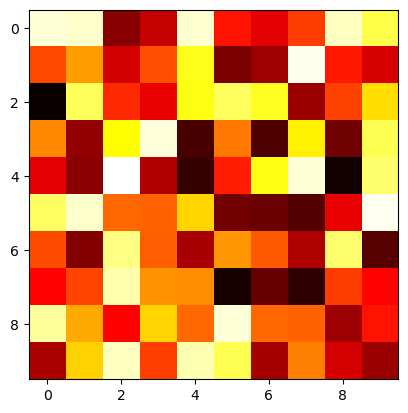

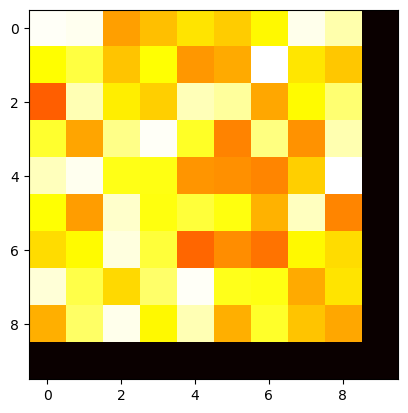

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import logging
logging.getLogger().setLevel(logging.INFO)

from part_assembly.stage4 import matrix_reduction

# Generate a random matrix for demonstration
matrix = np.random.rand(10, 10)
matrix = torch.Tensor(matrix)

# Plot the matrix as a heatmap
plt.imshow(matrix, cmap='hot', interpolation='nearest')

# Show the plot
plt.show()

new_matrix = matrix_reduction(matrix, 4, 5)

# Plot the matrix as a heatmap
plt.imshow(new_matrix, cmap='hot', interpolation='nearest')

# Show the plot
plt.show()



In [2]:

import torch

def top_k_indices(similarity_matrix, k):
    # Flatten the matrix and get the values and indices of top-k elements
    values, indices = torch.topk(similarity_matrix.view(-1), k)
    
    # Convert to 2D indices
    indices = torch.stack((indices // similarity_matrix.size(1), indices % similarity_matrix.size(1)), dim=1)
    
    return indices

similarity_matrix = torch.Tensor([[1, 2, 10], [4, 5, 6], [7, 8, 9]])
print(top_k_indices(similarity_matrix, 3))

tensor([[0, 2],
        [2, 2],
        [2, 1]])


/tmp/ipykernel_687/2408107736.py:8: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = torch.stack((indices // similarity_matrix.size(1), indices % similarity_matrix.size(1)), dim=1)


In [29]:
def at_operation(v1, v2):
    # Assuming a generic binary operation
    if v1 == 1 and v2 == 2:
        return 10000
    if v1 == 3 and v2 == 4:
        return 10000
    
    return v1 * v2 / 2  # This is a placeholder. Please replace it with the actual operation.

class Node:
    id_counter = 0

    def __init__(self, val, elements, history):
        self.id = Node.id_counter
        Node.id_counter += 1
        self.val = val
        self.elements = elements
        self.history = history

    def __lt__(self, other):
        return self.id < other.id

    def __eq__(self, other):
        return self.id == other.id

    def __hash__(self):
        return self.id


In [32]:
from itertools import combinations

# Sample data
numbers = [1, 2, 3, 4]
length = 2

# Generate combinations
combinations_list = list(combinations(numbers, length))

# Print the combinations
for combination in combinations_list:
    print(combination)


(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)


In [30]:
import heapq
def bfs(v):
    # Create initial nodes
    nodes = [Node(0, frozenset([x]), [(x,)]) for x in v]
    visited = set(nodes)
    max_value = max(node.val for node in nodes)
    max_history = []

    # Priority queue with elements in form (-value, node)
    # We use negative value because heapq in python is a min heap
    priority_queue = [(-node.val, node) for node in nodes]
    heapq.heapify(priority_queue)

    while priority_queue:
        # Pop the node with the highest value
        neg_value, node = heapq.heappop(priority_queue)
        value = -neg_value

        # Check if we have used all values
        if len(node.elements) == len(v):
            if value > max_value:
                max_value = value
                max_history = node.history
            continue

        # Create new nodes by combining current node with remaining nodes
        remaining_nodes = [n for n in nodes if n.elements.isdisjoint(node.elements)]
        for remaining_node in remaining_nodes:
            new_val = at_operation(node.val, remaining_node.val)
            new_elements = node.elements.union(remaining_node.elements)
            new_history = node.history + [(node.val, remaining_node.val, new_val)]
            new_node = Node(new_val, new_elements, new_history)

            if new_node not in visited:
                visited.add(new_node)
                heapq.heappush(priority_queue, (-new_val, new_node))

    return max_value, max_history


In [31]:
n = 5
v = [1, 2, 3, 4, 5]
max_value, max_history = bfs(v)
print("Operation history:")
for op in max_history[1:]:
    print(f"{op[0]} @ {op[1]} = {op[2]}")


Operation history:
1 @ 2 = 10000
10000 @ 5 = 25000.0
25000.0 @ 4 = 50000.0
50000.0 @ 3 = 75000.0
